In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [181]:
df = pd.read_csv("train.csv")
df = df[df["label"] != "label"]
df["label"] = df["label"].astype(int)

/tmp/ipykernel_34097/2992545920.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("train.csv")


In [182]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    m = y_true.shape[0]
    log_likelihood = -np.log(y_pred[range(m), y_true])
    loss = np.sum(log_likelihood) / m
    return loss

def one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [183]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, reg_lambda=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, hidden_size) * 0.01
        self.b2 = np.zeros((1, hidden_size))
        self.W3 = np.random.randn(hidden_size, output_size) * 0.01
        self.b3 = np.zeros((1, output_size))
        self.reg_lambda = reg_lambda
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.momentum_W1 = np.zeros_like(self.W1)
        self.momentum_b1 = np.zeros_like(self.b1)
        self.momentum_W2 = np.zeros_like(self.W2)
        self.momentum_b2 = np.zeros_like(self.b2)
        self.momentum_W3 = np.zeros_like(self.W3)
        self.momentum_b3 = np.zeros_like(self.b3)
        self.rmsprop_W1 = np.zeros_like(self.W1)
        self.rmsprop_b1 = np.zeros_like(self.b1)
        self.rmsprop_W2 = np.zeros_like(self.W2)
        self.rmsprop_b2 = np.zeros_like(self.b2)
        self.rmsprop_W3 = np.zeros_like(self.W3)
        self.rmsprop_b3 = np.zeros_like(self.b3)
        self.t = 0
        
    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = relu(self.Z2)
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = softmax(self.Z3)
        return self.A3
    
    def backward(self, X, Y, learning_rate=0.01):
        m = Y.shape[0]
        Y = one_hot(Y, self.A3.shape[1])
        
        dZ3 = self.A3 - Y
        dW3 = (1/m) * np.dot(self.A2.T, dZ3) + (self.reg_lambda / m) * self.W3
        db3 = (1/m) * np.sum(dZ3, axis=0, keepdims=True)
        
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * relu_derivative(self.Z2)
        dW2 = (1/m) * np.dot(self.A1.T, dZ2) + (self.reg_lambda / m) * self.W2
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
        
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = (1/m) * np.dot(X.T, dZ1) + (self.reg_lambda / m) * self.W1
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)
        
        # Update weights and biases using ADAM optimization
        self.t += 1
        self.momentum_W1 = self.beta1 * self.momentum_W1 + (1 - self.beta1) * dW1
        self.momentum_b1 = self.beta1 * self.momentum_b1 + (1 - self.beta1) * db1
        self.momentum_W2 = self.beta1 * self.momentum_W2 + (1 - self.beta1) * dW2
        self.momentum_b2 = self.beta1 * self.momentum_b2 + (1 - self.beta1) * db2
        self.momentum_W3 = self.beta1 * self.momentum_W3 + (1 - self.beta1) * dW3
        self.momentum_b3 = self.beta1 * self.momentum_b3 + (1 - self.beta1) * db3
        
        self.rmsprop_W1 = self.beta2 * self.rmsprop_W1 + (1 - self.beta2) * dW1**2
        self.rmsprop_b1 = self.beta2 * self.rmsprop_b1 + (1 - self.beta2) * db1**2
        self.rmsprop_W2 = self.beta2 * self.rmsprop_W2 + (1 - self.beta2) * dW2**2
        self.rmsprop_b2 = self.beta2 * self.rmsprop_b2 + (1 - self.beta2) * db2**2
        self.rmsprop_W3 = self.beta2 * self.rmsprop_W3 + (1 - self.beta2) * dW3**2
        self.rmsprop_b3 = self.beta2 * self.rmsprop_b3 + (1 - self.beta2) * db3**2
        
        mW1_hat = self.momentum_W1 / (1 - self.beta1**self.t)
        mb1_hat = self.momentum_b1 / (1 - self.beta1**self.t)
        mW2_hat = self.momentum_W2 / (1 - self.beta1**self.t)
        mb2_hat = self.momentum_b2 / (1 - self.beta1**self.t)
        mW3_hat = self.momentum_W3 / (1 - self.beta1**self.t)
        mb3_hat = self.momentum_b3 / (1 - self.beta1**self.t)
        
        rmsW1_hat = self.rmsprop_W1 / (1 - self.beta2**self.t)
        rmsb1_hat = self.rmsprop_b1 / (1 - self.beta2**self.t)
        rmsW2_hat = self.rmsprop_W2 / (1 - self.beta2**self.t)
        rmsb2_hat = self.rmsprop_b2 / (1 - self.beta2**self.t)
        rmsW3_hat = self.rmsprop_W3 / (1 - self.beta2**self.t)
        rmsb3_hat = self.rmsprop_b3 / (1 - self.beta2**self.t)
        
        self.W1 -= learning_rate * mW1_hat / (np.sqrt(rmsW1_hat) + self.epsilon)
        self.b1 -= learning_rate * mb1_hat / (np.sqrt(rmsb1_hat) + self.epsilon)
        self.W2 -= learning_rate * mW2_hat / (np.sqrt(rmsW2_hat) + self.epsilon)
        self.b2 -= learning_rate * mb2_hat / (np.sqrt(rmsb2_hat) + self.epsilon)
        self.W3 -= learning_rate * mW3_hat / (np.sqrt(rmsW3_hat) + self.epsilon)
        self.b3 -= learning_rate * mb3_hat / (np.sqrt(rmsb3_hat) + self.epsilon)


In [184]:
# Assuming X is your input data and Y are your labels
# X = np.random.randn(number_of_samples, 784)  # Example input
X = df.drop("label", axis=1).values
# Y = np.array([0, 1, 2, ..., 9])  # Example labels (for 10 classes)
Y = np.array(df["label"].values)

# Example usage
learning_rate = 0.01
input_size = X.shape[1]
hidden_size = 100
output_size = 10
layers = 4
model = NeuralNetwork(input_size, hidden_size, output_size)

In [185]:
# Forward pass
predictions = model.forward(X)

# Compute loss
loss = cross_entropy_loss(predictions, Y)

# Backward pass and update weights
model.backward(X, Y, learning_rate)


cost = []

In [187]:
epochs = 3000
learning_rate = 0.001
for i in range(1,epochs):
    print(f"{i}, {loss}")
    predictions = model.forward(X)
    loss = cross_entropy_loss(predictions, Y)
    cost.append(loss)
    model.backward(X, Y, learning_rate)
    if i % 700 == 0:
        learning_rate *= 0.1

1, 1.597212494352614
2, 1.597212494352614
3, 1.5891349350688466
4, 1.5924913125446016
5, 1.5942063636471975
6, 1.593740803463656
7, 1.579146909599397
8, 1.5749109410808833
9, 1.5866535322839623
10, 1.5721376448671467
11, 1.5822764202030073
12, 1.5774610889609781
13, 1.5778734902207565
14, 1.5721589698674672
15, 1.5740511599486968
16, 1.5761866385677736
17, 1.57145336337385
18, 1.5720363287065346
19, 1.5692517904669663
20, 1.5697556388114384
21, 1.565476932397965
22, 1.5790041406580781
23, 1.5721642708490935
24, 1.581610653762803
25, 1.5673109549449213
26, 1.5634085887381337
27, 1.560496679460434
28, 1.5561052161824696
29, 1.56614863980068
30, 1.563410778118684
31, 1.573671329607867
32, 1.5676974275680602
33, 1.5690143308702282
34, 1.5723428072155452
35, 1.5664803438183281
36, 1.5663451993546196
37, 1.555042381278918
38, 1.5523292814714913
39, 1.551935025899099
40, 1.5452707531148353
41, 1.5488174164084092
42, 1.5474668210793765
43, 1.5477991358592615
44, 1.5563363132878683
45, 1.562569

73.10665190151049 1.265327949543624
1.265327949543624


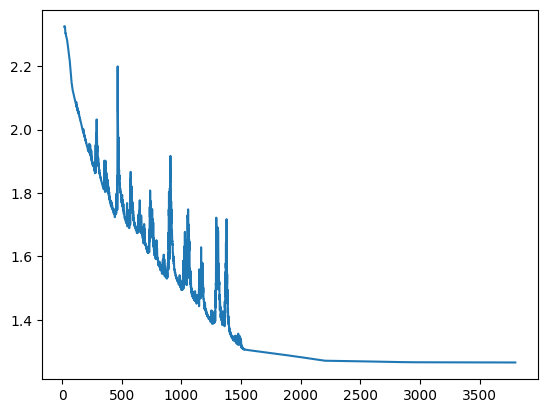

In [191]:

plt.plot(np.linspace(20, 3797, 3777), np.array(cost)[20:-1])

print(cost[0], cost[-1])

print(min(cost))


In [192]:

def predict(model, X):
    """Make predictions with the model."""
    logits = model.forward(X)
    return softmax(logits)

def test_model(model, X_test, y_test):
    """Test the model on the test dataset and return the accuracy."""
    predictions = predict(model, X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(y_test, axis=1)
    accuracy = np.mean(predicted_classes == actual_classes)
    return accuracy


In [193]:
df_test = pd.read_csv("test.csv")
df_test = df[df["label"] != "label"]
df_test["label"] = df["label"].astype(int)
df_test.head()

/tmp/ipykernel_34097/3691834882.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv("test.csv")


,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,7,41,10,8,3,4,7,0,4,0,...,112,87,38,45,41,46,53,40,49,47
1,7,130,106,83,64,61,66,64,64,64,...,67,66,65,61,61,63,64,64,64,64
2,7,37,41,38,38,40,39,40,38,39,...,50,149,151,160,161,84,104,105,100,99
3,7,46,47,40,34,19,24,24,24,24,...,42,46,48,34,27,39,49,55,37,46
4,7,15,21,14,24,24,14,15,19,8,...,32,30,27,27,27,112,78,74,70,70


In [194]:
# Example usage:
# Assuming model is your trained SimpleCNN model
#X_test = np.random.randn(num_test_samples, 784)  # Example test input
X_test = df_test.drop("label", axis=1).values
#y_test = np.eye(10)[np.random.choice(10, num_test_samples)]  # Example test labels (one-hot encoded)
Y_test = np.eye(10)[np.array(df_test["label"].values)]

accuracy = test_model(model, X_test, Y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 57.14%
